c:\Users\Ishraq\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifi

Ensemble Model Evaluation:


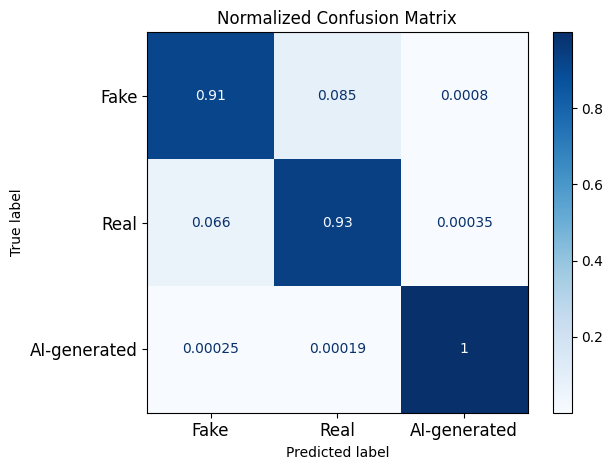


Accuracy: 0.9639645447219984
Precision: 0.9639962131949149
Recall: 0.9639645447219984
F1 Score: 0.9639776731105573


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from transformers import DebertaForSequenceClassification, DebertaTokenizer, RobertaForSequenceClassification, RobertaTokenizer
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class FakeNewsDataset(Dataset):
    def __init__(self, mode, tokenizer, path, max_seq_length=512):
        assert mode in ['train', 'val']
        self.mode = mode
        self.df = pd.read_csv(path, sep='\t').fillna('')
        self.len = len(self.df)
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __getitem__(self, idx):
        statement, label = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(label)

        tokens = self.tokenizer.tokenize(statement)[:self.max_seq_length - 2]
        tokens = [self.tokenizer.cls_token] + tokens + [self.tokenizer.sep_token]

        ids = self.tokenizer.convert_tokens_to_ids(tokens)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = None
        if isinstance(self.tokenizer, DebertaTokenizer):
            segments_tensor = torch.tensor([0] * len(tokens), dtype=torch.long)

        label_tensor = torch.zeros(NUM_LABELS)
        label_tensor[label] = 1

        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples if s[1] is not None]
    label_ids = torch.stack([s[2] for s in samples])

    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    if len(segments_tensors) > 0:
        segments_tensors = pad_sequence(segments_tensors, batch_first=True)
        return tokens_tensors, segments_tensors, masks_tensors, label_ids
    else:
        return tokens_tensors, None, masks_tensors, label_ids

BATCH_SIZE = 32
MODEL_NAME_DEBERTA = 'microsoft/deberta-base'
MODEL_NAME_ROBERTA = 'roberta-base'
NUM_LABELS = 3
MAX_SEQ_LENGTH = 256
train_path = 'train.tsv'
val_path = 'val.tsv'
model_path_deberta = 'deberta_model.pt'
model_path_roberta = 'roberta_model.pt'

tokenizer_deberta = DebertaTokenizer.from_pretrained(MODEL_NAME_DEBERTA)
tokenizer_roberta = RobertaTokenizer.from_pretrained(MODEL_NAME_ROBERTA)
model_deberta = DebertaForSequenceClassification.from_pretrained(MODEL_NAME_DEBERTA, num_labels=NUM_LABELS)
model_roberta = RobertaForSequenceClassification.from_pretrained(MODEL_NAME_ROBERTA, num_labels=NUM_LABELS)

model_deberta.load_state_dict(torch.load(model_path_deberta))
model_roberta.load_state_dict(torch.load(model_path_roberta))

valset = FakeNewsDataset('val', tokenizer=tokenizer_deberta, path=val_path, max_seq_length=MAX_SEQ_LENGTH)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_deberta.to(device)
model_roberta.to(device)

def apply_post_processing(tokens_tensors, pred, probabilities):
    for i, tokens in enumerate(tokens_tensors):
        text = tokenizer_deberta.decode(tokens)
        max_prob = torch.max(probabilities[i])
        
        if max_prob < 0.8:  # Increased threshold for applying rules
            if 'real' in text.lower() or 'true' in text.lower() or 'factual' in text.lower():
                pred[i] = 1
            elif 'ai generated' in text.lower() or 'artificial intelligence' in text.lower() or 'machine learning' in text.lower():
                pred[i] = 2
            elif 'fake' in text.lower() or 'false' in text.lower() or 'misinformation' in text.lower():
                pred[i] = 0
    return pred

def evaluate_ensemble(valloader):
    true = []
    predictions = []
    with torch.no_grad():
        model_deberta.eval()
        model_roberta.eval()
        for data in valloader:
            tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
            
            outputs_deberta = model_deberta(input_ids=tokens_tensors, token_type_ids=segments_tensors, attention_mask=masks_tensors)
            outputs_roberta = model_roberta(input_ids=tokens_tensors, attention_mask=masks_tensors)

            logits_deberta = outputs_deberta.logits
            logits_roberta = outputs_roberta.logits

            # Adjust weights
            weight_deberta = 0.6
            weight_roberta = 0.4
            logits = (weight_deberta * logits_deberta + weight_roberta * logits_roberta)

            softmax = torch.nn.Softmax(dim=1)
            probabilities_deberta = softmax(logits_deberta)
            probabilities_roberta = softmax(logits_roberta)
            probabilities = softmax(logits)
            
            # Use model-specific thresholds
            threshold_deberta = 0.8
            threshold_roberta = 0.8
            pred_deberta = torch.argmax(logits_deberta, dim=1)
            pred_roberta = torch.argmax(logits_roberta, dim=1)
            
            # Implement voting system
            pred = torch.where(pred_deberta == pred_roberta, pred_deberta,
                               torch.where(probabilities.max(dim=1)[0] > 0.9, torch.argmax(logits, dim=1),
                                           torch.tensor(-1).to(device)))

            # Use probabilities for uncertain predictions
            uncertain_mask = pred == -1
            pred[uncertain_mask] = torch.argmax(probabilities[uncertain_mask], dim=1)

            pred = apply_post_processing(tokens_tensors, pred, probabilities)

            labels = data[3]
            true.extend(torch.argmax(labels, dim=1).cpu().tolist())
            predictions.extend(pred.cpu().tolist())

    cm = confusion_matrix(true, predictions, labels=[0, 1, 2], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real', 'AI-generated'])
    disp.plot(cmap='Blues')

    disp.ax_.set_title('Normalized Confusion Matrix')
    disp.ax_.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

    accuracy = accuracy_score(true, predictions)
    precision = precision_score(true, predictions, average='weighted')
    recall = recall_score(true, predictions, average='weighted')
    f1 = f1_score(true, predictions, average='weighted')

    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

print('Ensemble Model Evaluation:')
evaluate_ensemble(valloader)